## Calculation of anisotropic superconductivity

Author: S. Mishra (v1.1, 06/01/2024) <br>
Revision: S. Mishra (v1.2, 11/25/2024) <br>

In this notebook, we calculate the superconductivity properties of MgB$_2$ by solving the
anisotropic Migdal-Eliashberg equations. The theory related to this tutorial can be found in 
[Phys. Rev. B **87**, 024505 (2013)](https://doi.org/10.1103/PhysRevB.87.024505) which are also briefly discussed in this notebook. 

Electrons and phonons are computed with Quantum ESPRESSO (QE), maximally-localized Wannier functions are computed with Wannier90, and superconductivity is computed with EPW. Using EPW, we do the following:

1. We interpolate the electron-phonon matrix elements to fine **k** and **q** grids;
2. Solve the Migdal-Eliashberg equations in the imaginary and real frequencies at different temperatures;
3. We compared the solution of Migdal-Eliashberg equations with and without assuming the constant density of states. 

NOTE: For this example, we use very coarse $k$- and $q$-grids. For actual calculations, one should use much denser grids.

#### Set up working environment

In [1]:
import numpy as np
import sys, os
sys.path.insert(0,str(os.getcwd())+'/../')
from EPWpy import EPWpy
from EPWpy.plotting import plot_supercond
pathQE='/home/shashi-phy/codes/q-e/bin'
print(pathQE)

/home/shashi-phy/codes/q-e/bin


Below we define constants that will remail unchanged throughout the Notebook. The object `mgb2` is created as an instance of the `EPWpy` class. This object will contain everything that we need to execute and analyze the calculations.

#### Set paths to relevant directories:

In [2]:
prefix='mgb2'
pseudo='/home/shashi-phy/codes/epw_notebook/pseudos'
# Maximum number of cores to be used
cores = 8
print('Maximum number of cores to be used:', cores)

Maximum number of cores to be used: 8


#### Create Calculation Object
Define general calculation parameters to be used throughout the workflow:

In [3]:
mgb2=EPWpy.EPWpy({'prefix':prefix,
            'restart_mode':'\'from_scratch\'',
            'calculation':'\'scf\'',
            'ibrav':4,
            'nat':3,
            'ntyp':2,
            'atomic_species':['Mg', 'B'],
            'celldm(1)':'5.8260252227888',
            'celldm(3)':'1.1420694129095',
            'atoms':['Mg', 'B', 'B'],
            'atomic_pos':np.array([[0.0, 0.0, 0.0], [0.3333,0.66667,0.5],[0.66667,0.3333,0.5]]), 
            'atomic_position_type':'crystal', 
            'mass':[24.305, 10.811],
            'pseudo':['Mg.pz-n-vbc.UPF', 'B.pz-vbc.UPF'],
            'ecutwfc':'40',
            'ecutrho':'160',
            'smearing':'\'mp\'',
            'occupations':'\'smearing\'',
            'degauss':'0.05',
            'pseudo_dir':'\''+str(pseudo)+'\''},
            code=pathQE,
            env='mpirun',system = prefix)
#######Printing any attribute######
pseudopot=mgb2.__dict__['pw_atomic_species']['pseudo']
print('prefix:', mgb2.__dict__['pw_control']['prefix'])
print('pseudopotential:', mgb2.__dict__['pw_atomic_species']['pseudo'][0])
print('pseudopotential directory:', mgb2.__dict__['pw_control']['pseudo_dir'])


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

### Self-Consistent Field (SCF) Calculations

We first solve the Kohn-Sham equations to obtain the Kohn-Sham orbitals $\phi_v(r)$, where $r$ is the electronic position (generally a mesh grid), and $R$ is the position of ions.

$E[\phi_v,R]=-\frac{\hbar^2}{2m}\sum_v{\int{\phi_v^\star(r)\nabla^2\phi_v(r)dr}+\int{V_R(r)n(r)dr}+\frac{e^2}{2}\int{\frac{n(r)n(r')}{|r-r'|}drdr'}+E_{xc}[n(r')]+\sum_{I\neq J}{\frac{e^2}{2}\frac{Z_IZ_J}{|R_I-R_J|}}}$

We minimize $E(R)=min(E[\phi_v,R])$

Where, $\Big(-\frac{\hbar^2}{2m}\nabla^2+V_{KS}(r)\Big)\phi_v(r)=\epsilon_v\phi_v(r)$

In [4]:
mgb2.scf(kpoints={'kpoints':[[8,8,8]],'type':'automatic'},name='scf')
mgb2.prepare(1,type_run='scf')
mgb2.run(cores, type_run='scf')

-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 0.0s (4366.51/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Band Structure Calculation

We now calculate the band structure of the material.

The band structure is the eigenenergies of KS orbitals at various points in the Brillouin zone.
We choose a path that passes through all the high symmetry $k$-points.

$\Big(-\frac{\hbar^2}{2m}|k+G|^2+V_{KS}(G-G')\Big)\phi_v(k)=\epsilon_v(k)\phi_v(k)$

In [5]:
mgb2.scf(control={'calculation':'\'bands\''},
         kpoints={'kpoints':[['0.0', '0.0', '0.0', '20'],
                            ['0.333', '0.333', '0.0', '20'],
                            ['0.5', '0.0', '0.0', '20'],
                            ['0.0', '0.0', '0.0', '20'],
                            ['0.0', '0.0', '0.5', '20'],
                            ['0.333', '0.333', '0.5', '20'],
                            ['0.5','0.0','0.5','20'],
                            ['0.0', '0.0', '0.5', '20']],
                  'kpoints_type':'{crystal_b}'},
            name='bs')

########################################
mgb2.prepare(1,type_run='bs')
mgb2.run(cores,type_run='bs')

-- -- -- -- -- -- -- -- -- -- --  Calculation: bs  -- -- -- -- -- -- -- -- -- -- -- 
Running bs |████████████████████████████████████████| in 0.0s (5391.53/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [6]:
mgb2.bands(name='bands')
mgb2.prepare(1,type_run='bands')
# Running on too many cores will cause the job to fail
mgb2.run(cores,type_run='bands')

-- -- -- -- -- -- -- -- -- -- --  Calculation: bands  -- -- -- -- -- -- -- -- -- -- -- 
Running bands |████████████████████████████████████████| in 0.0s (4166.66/s)    

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Plotting band structure

The band structure is given in the file `bands.dat` and plottable bands are written to `bands.dat.gnu`, which
contains two columns The first column is the distance along the $k$‐path, and the second column is the energies (eV).  We will use this file for plotting as below.

Plot saved as: mgb2_band.pdf


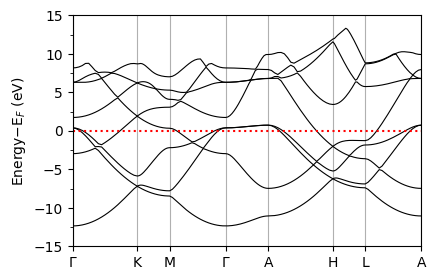

In [4]:
ef = plot_supercond.get_fermi(prefix)
xticks=['$\Gamma$','K', 'M', '$\Gamma$', 'A', 'H', 'L', 'A']
plot_supercond.band_plot(prefix, xticks, ylim=(-15,15))

#### Density of states (DOS) calculation using tetrahedron method

In [6]:
mgb2.scf_fold='scf'
mgb2.scf(control={'calculation':'\'nscf\''},
        system={'occupations':'\'tetrahedra\''},
        kpoints={'kpoints':[[8,8,8]],
                'kpoints_type':'automatic'},
        name = 'nscf2')

mgb2.prepare(1, type_run='nscf2')
mgb2.run(cores, type_run='nscf2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf2  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf2 |████████████████████████████████████████| in 0.0s (10021.23/s)   

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [7]:
ef = plot_supercond.get_fermi(prefix)
mgb2.dos(dos={'prefix':prefix,
            'Emin':ef - 15,
            'Emax':ef + 15})
mgb2.prepare(1,type_run='dos')
mgb2.run(cores,type_run='dos')

-- -- -- -- -- -- -- -- -- -- --  Calculation: dos  -- -- -- -- -- -- -- -- -- -- -- 
Running dos |████████████████████████████████████████| in 0.0s (2422.14/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plotting the Band Structure and DOS

We now plot the band structure of the material.

Plot saved as: mgb2_band_dos.pdf


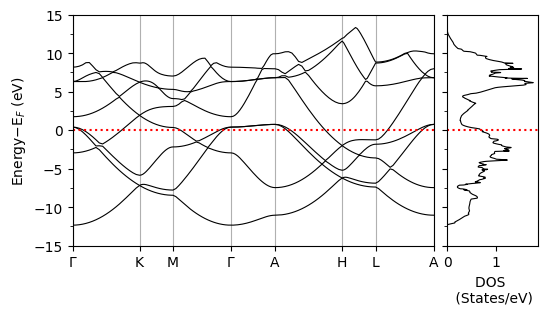

In [8]:
xticks=['$\Gamma$','K', 'M', '$\Gamma$', 'A', 'H', 'L', 'A']
plot_supercond.bandos_2plot(prefix, xticks)

### Phonon Calculations

In order to obtain the Eliashberg spectral function, we need the electron-phonon interactions, 
which are the first derivatives of the lattice potential with respect to the atomic displacements.
We also need the phonon frequencies and the displacement vectors.
We obtain all these quantities using the density-functional perturbation theory [(DFPT)](https://link.aps.org/doi/10.1103/RevModPhys.73.515), as discussed in the [tutorial](https://docs.epw-code.org/_downloads/b3f5899664a87fcdd6dcacc262e6f103/Mon.1.Giannozzi.pdf).

We solve here using a $3 \times 3 \times 3$ $q$-grid.

In [9]:
mgb2.ph(phonons={'fildyn':'\'mgb2.dyn\'','nq1':3,'nq2':3,'nq3':3,'fildvscf':'\'dvscf\''})
mgb2.prepare(4,type_run='ph')
mgb2.run(cores,type_run='ph')

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 0.1s (2243.23/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Phonon Dispersion Calculation

We begin by evaluating the interatomic force constants obtained via second derivatives of the total potential energy, 
$C_{\kappa\alpha\rho\kappa'\alpha'\rho'}=\frac{\partial^{2}U}{\partial\tau_{\kappa\alpha\rho}\partial\tau_{\kappa'\alpha'\rho'}}$

In [9]:
mgb2.ph_fold='ph'
mgb2.q2r(name='q2r')
mgb2.prepare(1,type_run='q2r')
mgb2.run(4,type_run='q2r')

-- -- -- -- -- -- -- -- -- -- --  Calculation: q2r  -- -- -- -- -- -- -- -- -- -- -- 
Running q2r |████████████████████████████████████████| in 0.0s (5056.77/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [10]:
mgb2.matdyn(matdyn={'flfrq':'\''+str(prefix)+'.freq\'',
                    'flfrc':str(prefix)+'.fc'},
            kpoints={'kpoints':[['0.0', '0.0', '0.0', '20'],
                            ['0.333', '0.333', '0.0', '20'],
                            ['0.5', '0.0', '0.0', '20'],
                            ['0.0', '0.0', '0.0', '20'],
                            ['0.0', '0.0', '0.5', '20'],
                            ['0.333', '0.333', '0.5', '20'],
                            ['0.5','0.0','0.5','20'],
                            ['0.0', '0.0', '0.5', '1']]},
            name='matdyn')

mgb2.prepare(1,type_run='matdyn')
mgb2.run(4,type_run='matdyn')

-- -- -- -- -- -- -- -- -- -- --  Calculation: matdyn  -- -- -- -- -- -- -- -- -- -- -- 
Running matdyn |████████████████████████████████████████| in 0.0s (7348.71/s)   

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Phonon DOS Calculation

In [11]:
mgb2.phdos(name='phdos',
          phdos={'flfrq':'\''+str(prefix)+'.dos.freq\'',
                  'flfrc':'\''+str(prefix)+'.fc\'',
                  'fldos':'\''+str(prefix)+'.dos\'',
                  'dos':'.true.',
                  'nk1':12,
                  'nk2':12,
                  'nk3':12,})
## Prepare folders and copy necessary files ##
mgb2.prepare(1,type_run='phdos')
## Run calculation ##
mgb2.run(cores,type_run='phdos')

-- -- -- -- -- -- -- -- -- -- --  Calculation: phdos  -- -- -- -- -- -- -- -- -- -- -- 
Running phdos |████████████████████████████████████████| in 0.0s (8388.52/s)    

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plotting Phonon Dispersion and DOS


Plot saved as: mgb2_phonons.pdf


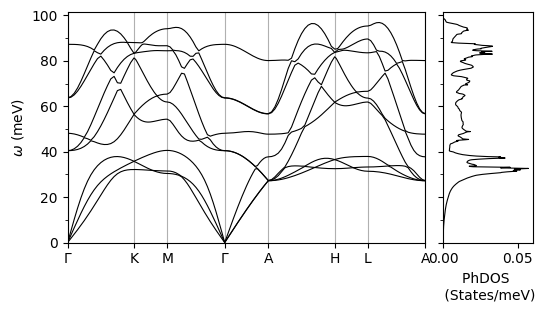

In [12]:
xticks=['$\Gamma$','K', 'M', '$\Gamma$', 'A', 'H', 'L', 'A']
plot_supercond.phonon_plot(prefix, xticks)

### Transformation of electrons and phonons to Wannier basis with EPW

Now we have Kohn-Sham wavefunctions and variations of the self-consistent Kohn-Sham potential on coarse Brillouin zone grid. We will generate the electron Hamiltonian, the IFCs, and the electron-phonon matrix elements in the Wannier representation using [EPW](https://epw-code.org/). Details on the underlying formalism can be found [here](https://arxiv.org/abs/1603.06965) (free version) or [here](https://doi.org/10.1103/RevModPhys.89.015003) (journal version).

This operation involves four logical steps:
1. Compute Kohn-Sham states on a uniform $\Gamma$ centered Brillouin zone grid (QE) between [0, 1] in crystal coordinates 
2. Use EPW to load these states and call Wannier90 to generate Wannier functions
3. Use EPW to load IFCs (or dynamical matrices) and potential variations, and combine with step 2 to compute electron-phonon matrix elements in the Bloch representation
4. Use EPW to perform the transformation to the Wannier basis and write to file

#### Step 1: Calculations of Kohn-Sham states on uniform Brillouin zone grid

We now perform a non-self-consistent DFT calculation on a homogeneous $\Gamma$ centered $k$-point grid of $6 \times 6 \times 6$.

In [15]:
mgb2.nscf(control={'calculation':'\'bands\''},
          system={'nbnd':10, 
                  'smearing':'\'mp\'',
                  'occupations':'\'smearing\'',
                  'degauss':'0.05',},
          kpoints={'grid':[6, 6, 6],'kpoints_type': 'crystal'})
mgb2.prepare(1, type_run='nscf')
######### Run #####################
mgb2.run(cores, type_run='nscf')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 0.0s (5710.30/s)     

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Steps 2-4: Load Bloch representation, Wannierize, write to file quantities in Wannier representation

Now, we have the phonon spectra, the dynamical matrix elements, and the electron-phonon interactions as discussed in the [RMP paper](https://link.aps.org/doi/10.1103/RevModPhys.89.015003).
We interpolate dynamical matrix elements, and the electron-phonon coupling matrices using the [EPW code](https://www.sciencedirect.com/science/article/pii/S0010465516302260). 

In [6]:
mgb2.ph_file='ph'
mgb2.ph_fold='ph'
mgb2.scf_fold='scf'
mgb2.nscf_file='nscf'
mgb2.nscf_fold='nscf'
mgb2.verbosity = 2
#kpath file
mgb2.filkf_file = 'mgb2.kpath.txt'

# EPW run 1: Bloch to Wannier
mgb2.epw(epwin={'wdata':['guiding_centres = .true.',
                       'dis_num_iter = 300',
                       'num_print_cycles  = 10',
                       'dis_mix_ratio = 1',
                       'use_ws_distance = T'],
                      'proj':['\'B:pz\'', '\'f=0.5,1.0,0.5:s\'', '\'f=0.0,0.5,0.5:s\'', '\'f=0.5,0.5,0.5:s\''],
                      'dis_froz_max':8.8,
                      'nbndsub':5,
                      'num_iter':500, 
                      'etf_mem':0, 
                      'elph':'.true.',
                      'band_plot':'.true.',
                      'filkf':mgb2.filkf_file,
                      'filqf':mgb2.filkf_file
                       },name='epw1')

mgb2.prepare(4, type_run='epw1') 
mgb2.run(cores, type_run='epw1')

(4, 3)
[51, 51, 51]
User-provided filkf: mgb2.kpath.txt
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw1  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 8 /home/shashi-phy/codes/q-e/bin/epw.x -nk 8 -in  epw1.in > epw1.out
Running epw1 |████████████████████████████████████████| in 0.0s (3753.06/s)     

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


##### Sanity check: Interpolated bands and phonons from EPW

At this point, we have all necessary quantities in the Wannier representation on file. As a sanity check, we perform a simple interpolation of bands and phonons to make sure that we reproduce the results found above _without_ Wannier interpolation.

In [7]:
#electron eigen energies 
mgb2.plotband(name='plotband')
mgb2.prepare(1,type_run='plotband')
mgb2.run(1,type_run='plotband')

-- -- -- -- -- -- -- -- -- -- --  Calculation: plotband  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /home/shashi-phy/codes/q-e/bin/plotband.x <  plotband.in > plotband.out
Running plotband |████████████████████████████████████████| in 0.0s (2975.62/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Plot saved as: mgb2_band.pdf


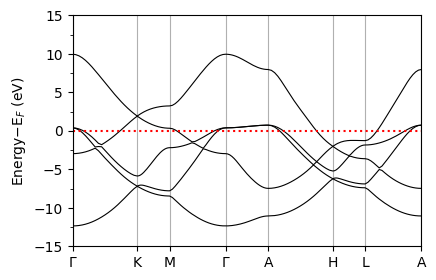

In [8]:
#ef = plot_supercond.get_fermi(prefix)
xticks=['$\Gamma$','K', 'M', '$\Gamma$', 'A', 'H', 'L', 'A']
sym_file = './mgb2/epw/plotband.out'  
band_file = './mgb2/epw/band.dat'    
plot_supercond.band_plot(prefix, xticks, band_file=band_file, sym_file=sym_file)

#### Interpolation of phonon frequencies

In [9]:
#Generate phonon interpolated band
mgb2.plotband(['phband.freq', 
             '0 100', # frequncy range
             'phband.dat']
            ,name='plotband')
mgb2.prepare(1, type_run='plotband')
mgb2.run(1, type_run='plotband')

-- -- -- -- -- -- -- -- -- -- --  Calculation: plotband  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /home/shashi-phy/codes/q-e/bin/plotband.x <  plotband.in > plotband.out
Running plotband |████████████████████████████████████████| in 0.0s (3900.05/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Reading data from: ./mgb2/epw/phband.dat
Plot saved as: mgb2_phonon_dispersion.pdf


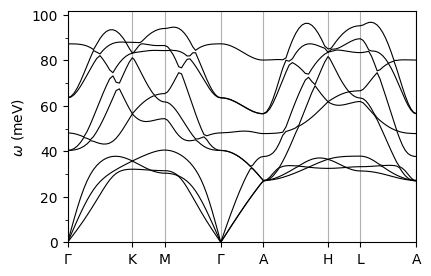

Reading data from: ./mgb2/ph/mgb2.freq.gp
Plot saved as: mgb2_phonon_dispersion.pdf


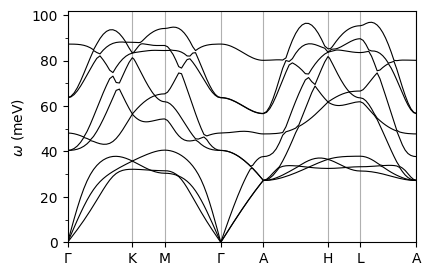

In [10]:
xticks=['$\Gamma$','K', 'M', '$\Gamma$', 'A', 'H', 'L', 'A']

#EPW interpolated band
plot_supercond.phband_plot(prefix, xticks, band_file='./mgb2/epw/phband.dat',sym_file='./mgb2/epw/plotband.out')

#QE phonon band
plot_supercond.phband_plot(prefix, xticks, band_file='./mgb2/ph/mgb2.freq.gp',sym_file='./mgb2/bs/bands.out')

#### Superconductivity Calculations

The theory related to this tutorial can be found in 
[Phys. Rev. B **87**, 024505 (2013)](https://doi.org/10.1103/PhysRevB.87.024505). Below we briefly discuss the theory.

The adiabatic self-energy can be written as:
$$
\Sigma_{nk}(i\omega_j) = -T \sum_{mk'}\sum_{j'} \sum_{\nu} |g_{nk,mk'}^{-q\nu}|^2 D^0_{q\nu}(i\omega_j-i\omega_{j'})\tau_{3}\Sigma_{mk'}(i\omega_{j'}) \tau_{3}
$$

where the dressed phonon propagator is expressed in terms of its spectral representation as
$$
D^0_{q\nu}(i\omega_j-i\omega_{j'}) = -\frac{2\omega_{q\nu}}{(\omega_j-\omega_{j'})^2 + \omega_{q\nu}^2} = \frac{2\omega_{q\nu}}{(i\omega_j-i\omega_{j'})^2 - \omega_{q\nu}^2}
$$

The anisotropic electron-phonon coupling strength is defined as follows,
$$
\lambda_{nk, mk+q}(\omega_j) = N_F \sum_{\nu} \frac{2\omega_{q\nu}}{\omega_j^2 + \omega_{q\nu}^2} \left|g_{nk,mk'}^{-q\nu}\right|^2 = \int_{0}^{\infty} d\omega \frac{2\omega}{\omega_j^2 + \omega^2} \alpha^2F_{nk,mk+q}(\omega) 
$$
where $N_F$ is the density of states at the Fermi energy.

The band- and wavevector-dependent electron-phonon coupling strength $\lambda_{nk}(\omega_j)$ is defined as:
$$
\lambda_{nk}(\omega_j) = \sum_{m} \int \frac{dq} {\Omega_{\rm BZ}} \frac{\delta(\varepsilon_{mk+q}-\varepsilon_F)}{N_F} \lambda_{nk, mk+q}(\omega_j)
$$

The isotropic electron-phonon coupling strength takes the following form
$$
\lambda(\omega_j) = \sum_{n} \int \frac{dk}{\Omega_{\rm BZ}}\frac{\delta(\varepsilon_{nk}-\varepsilon_F)}{N_F} \lambda_{nk}(\omega_j) 
$$

The standard electron-phonon coupling strength $\lambda$ found in the literature corresponds to setting 
$\omega_j=0$ in the isotropic electron-phonon coupling strength.

The anisotropic Eliashberg spectral functions is defined as 
$$
\alpha^2F_{nk,mk+q}(\omega) = N_F \sum_{\nu} \left|g_{nk,mk'}^{-q\nu}\right|^2 \delta(\omega-\omega_{q\nu})
$$

To compare with available experimental data, we define the Fermi-surface averaged spectral functions
 as follows (see [EPW paper](https://www.sciencedirect.com/science/article/pii/S0010465516302260)).

$$
\alpha^2F(\omega) = \frac{1}{N_F} \sum_{nm\nu} \int \frac{dk} {\Omega_{\rm BZ}} \int \frac{dq} {\Omega_{\rm BZ}} \left|g_{nk,mk'}^{-q\nu}\right|^2 \delta(\omega-\omega_{q\nu}) \delta(\varepsilon_{nk}-\varepsilon_F) \delta(\varepsilon_{mk+q}-\varepsilon_F) 
$$

From several studies, it was observed that $\alpha^2F(\omega)$ closely resembles the phonon density of states [$F(\omega)$](https://www.sciencedirect.com/science/article/pii/S0081194708606657). 

#### Fermi-Surface Restricted (FSR) Migdal-Eliashberg Equations

Following the procedure as discussed in [this paper](https://link.aps.org/doi/10.1103/PhysRevB.87.024505), we solve the anisotropic FSR Migdal-Eliashberg equations on the imaginary frequency axis by setting the keywords 
`eliashberg = .true.`, `laniso = .true.`, and `limag = .true.` in the EPW input file. 
The equations are solved self-consistently for each temperature specified in `temps` in the input file. 
The calculation  at each temperature ends when either the converge threshold (set with `conv_thr_iaxis`)
 or the maximum number of iterations (set with `nsiter`) is reached. 
    
The anisotropic FSR Migdal-Eliashberg equations take the following form:
$$
Z_{nk}(i\omega_j)= 1 + \frac{\pi T}{\omega_j N_F} \sum_{mj'}\int \frac{dq}{\Omega_{\rm BZ}}\frac{\omega_{j'}}{\sqrt{\omega_{j'}^2 + \Delta_{mk+q}^2}} \lambda_{nk,mk+q}(\omega_j - \omega_{j'}) \delta(\varepsilon_{mk+q}-\varepsilon_F)
$$
and
$$
Z_{nk}(i\omega_j) \Delta_{nk}(i\omega_j) = \frac{\pi T}{N_F} \sum_{m{j'}} \int \frac{dq} {\Omega_{\rm BZ}} 
\frac{\Delta_{mk+q}}{\sqrt{\omega_{j'}^2 + \Delta_{mk+q}^2}} \left[\lambda_{nk,mk+q}(\omega_j - \omega_{j'}) -\mu_c^*\right] \delta(\varepsilon_{mk+q}-\varepsilon_F)
$$
where $\lambda_{nk,mk+q}(\omega_j- \omega_{j'})$ is the anisotropic electron-phonon coupling strength. 
The semiempirical Coulomb parameter $\mu_c^*$ is provided as an input varible `muc` in the EPW calculation.

From these expressions, we observe that the necessary ingredients to solve the anisotropic ME 
equations are the Kohn-Sham eigenvalues, phonon frequencies, and electron-phonon matrix elements 
on the $k$- and $q$-grids. 

Once electron-phonon matrix elements on denser $k$- and $q$-grids are computed,
we will then solve the Eliashberg equations self-consistently to obtain the ansitropic
gap function. To understand the gap function, we will also analyze the electron-phonon coupling $\lambda$.

To compute the superconducting properties, we perform the following operations:
1. Fourier-transform the electron-phonon matrix elements and interpolate from a coarse $k$-grid of $6\times 6 \times 6$ and $q$-grid of 
$3 \times 3 \times 3$ to dense $20 \times 20 \times 20$ $k$-point and $10 \times 10 \times 10$ $q$-point grids, respectively. 

    - Pre-compute the $q$-points that fall within the Fermi window `fsthick`. If, at a specific $q$-point, at least one $k+q$ eigen energy falls within `fsthick` of the Fermi level, then the $q$-point is selected.
    - For superconductivity calculations, we must set `ephwrite = .true.`. This also requires  that the $k$- and $q$-grids be commensurate, i.e., `nkf1`, `nkf2`, `nkf3` to be integer multiples of `nqf1`, `nqf2`, `nqf3`, respectively.

2. We use the interpolated e-ph couplings to solve the Eliashberg expressions as discussed above. 

   - Write the Fermi surface files `mgb2.fs\_YY.cube` (YY = band index within the `fsthick`) and `mgb2.fs.frmsf` by setting `fermi_plot = .true.`. The `*.cube` files can be visualized with [VESTA](https://jp-minerals.org/vesta/en/) and the `*.frmsf` file can be visualized with [FermiSurfer](https://fermisurfer.osdn.jp/).
                                                                                                       
   - Calculate the isotropic and anisotropic electron-phonon coupling strength by setting the keywords `eliashberg = .true.` and `iverbosity = 2`. The expressions for isotropic and anisotropic electron-phonon coupling strengths are given above. 

   - Solve the anisotropic Migdal-Eliashberg equations on the imaginary frequency axis achieved by setting the keywords `laniso = .true.`, and `limag = .true.` in the input file. The equations are solved self-consistently for each temperature specified in the input file. The calculation  at each temperature ends when either the  converge threshold  or the maximum number of iterations is reached.


    - Perform the analytic continuation of the solutions along the imaginary frequency axis to the real frequency axis by using Pade approximants (from `lpade=.true.`). Note the analytic continuation with the iterative procedure (from `lacon = .true.`) is not performed since this is very expensive computationally in the anisotropic case (hours to days).

In [11]:
mgb2.epw(epwin={ 'elph':'.true.',
                 'fsthick':0.2,
                 'degaussw':0.05,
                 'degaussq':0.5, #phonon smearing
                 'ephwrite':'.true.',
                 'eliashberg':'.true.',
                 'iverbosity':2, 
                 'laniso':'.true.',
                 'limag':'.true.',
                 'lpade':'.true.',
                 'nsiter': '500',
                 'conv_thr_iaxis':'1.0d-3',
                 'wscut' :'0.5', # maximum matsubara freq. cutoff
                 'muc':'0.1', 
                 'nstemp':'4',
                 'temps':'10 30',
                 'nkf1':20,'nkf2':20,'nkf3':20,
                 'nqf1':10,'nqf2':10,'nqf3':10,
                 'mp_mesh_k':'.true.', # uses k-point symmetry
                 'clean_supercond':None},
         name='epw2')

mgb2.prepare(4,type_run='epw2') 
mgb2.run(cores,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 8 /home/shashi-phy/codes/q-e/bin/epw.x -nk 8 -in  epw2.in > epw2.out
Running epw2 |████████████████████████████████████████| in 0.0s (3139.89/s)     

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plotting the Isotropic and Anisotropic Electron-Phonon Coupling Strengths

-The files `mgb2.lambda_pairs`, `mgb2.lambda_k_pairs`, and `mgb2.a2f` are generated by setting
 `eliashberg = .true.` and `iverbosity = 2`.

-The `mgb2.lambda_pairs` file contains the anisotropic electron-phonon coupling strength $\lambda_{nq,mk+q}(0)$ 
on the Fermi surface.

-The `mgb2.lambda_k_pairs` file contains the band- and wavevector-dependent anisotropic electron-phonon coupling strength $\lambda_{nk}(0)$ on the Fermi surface.

-The `mgb2.a2f` file contains the isotropic Eliashberg spectral function $\alpha^2F(\omega)$ and cumulative
electron-phonon coupling strength as a function of frequency $\omega$(meV) for different phonon 
smearing values (see the end of the file for information about the smearing).

Plot saved as: ./mgb2_lambda_pairs.pdf


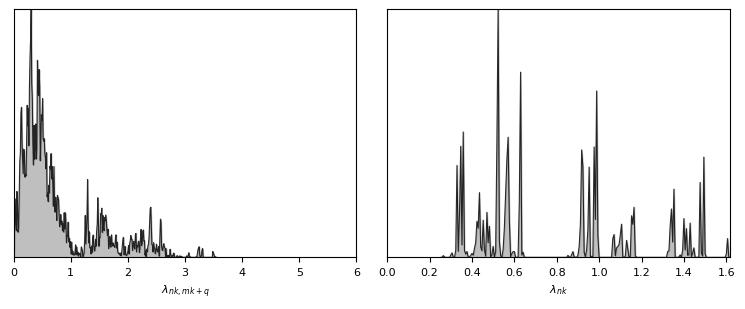

In [12]:
###Anisotropic electron-phonon coupling
lambda_pairs = "./mgb2/epw/mgb2.lambda_pairs"
lambda_k_pairs = "./mgb2/epw/mgb2.lambda_k_pairs"
plot_supercond.plot_lambda(prefix, lambda_pairs_file=lambda_pairs, lambda_k_pairs_file=lambda_k_pairs)
#plot_supercond.plot_lambda(prefix, font=10)

Plot saved as: mgb2_a2f_plot.pdf


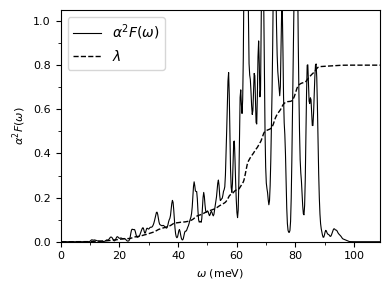

In [13]:
###Isotropic a2f and electron-phonon coupling
plot_supercond.plot_a2f(prefix)

Plot saved as: ./mgb2_aniso_iso_e-ph_coupling.pdf


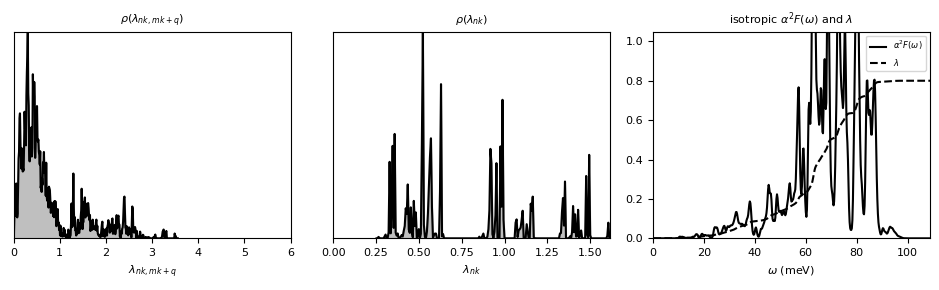

In [14]:
###Ansiotropic and isotropic electron-phonon coupling
plot_supercond.plot_lambda_aniso_iso(prefix)

##### Plotting anisotropic superconducting gap $\Delta$ along the imaginary and real frequency axis

Plot saved as: ./mgb2_gap_conv_Re_Im_axes.pdf


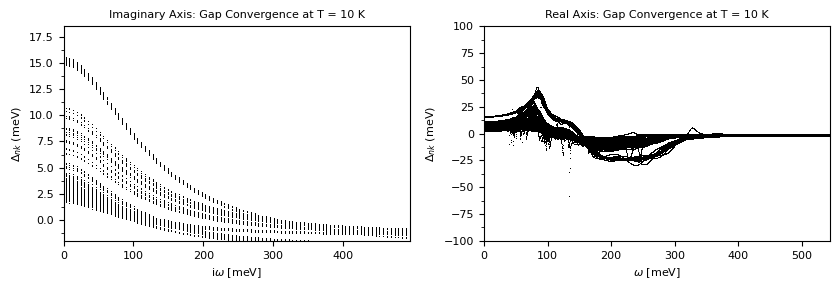

In [15]:
plot_supercond.gap_conv_aniso_real_imag(prefix, temp=10)

Plot saved as: ./mgb2_aniso_Im_gap_conv.pdf


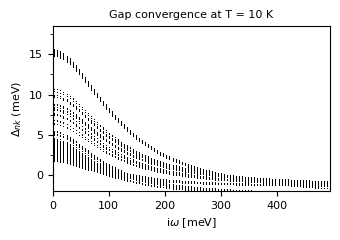

In [16]:
#plot_supercond.gap_conv_aniso_imag(prefix, temp=10)
imag_gap = "mgb2/epw/mgb2.imag_aniso_010.00"
plot_supercond.gap_conv_aniso_imag(prefix, temp=10, imag_gap_files=imag_gap)

##### Plotting Superconducting Gap as a function of Temperature

Plot saved as: /home/shashi-phy/codes/epw_notebook/notebooks_basic/mgb2_gap_aniso_vs_temp.pdf


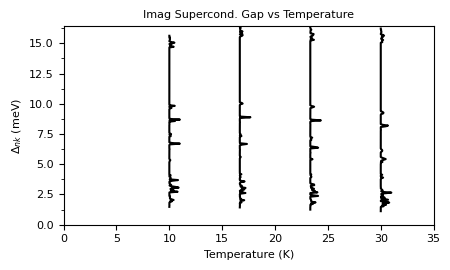

In [17]:
plot_supercond.gap_aniso_temp(prefix, tempmax=35, font=8)

#### Superconducting Quasiparticle DOS

The quasiparticle DOS in the superconducting state relative to the DOS in the 
normal state is given by:

$$
\frac{N_S(\omega)}{N_F} = \sum_{n} \int \frac{dk} {\Omega_{\rm BZ}} \frac{\delta(\varepsilon_{nk}-\varepsilon_{F})}{N_F} {\rm Re} \left[ \omega/\sqrt{\omega^2 - \Delta_{nk}(\omega)} \right]
$$

The `mgb2.qdos_XX` files contain the quasiparticle density of states in the superconducting state relative to the DOS in the normal state $N_S(\omega)/N_F$ as a function of frequency (eV) at various temperatures.

Plot saved as: ./mgb2_Qpdos_10.pdf


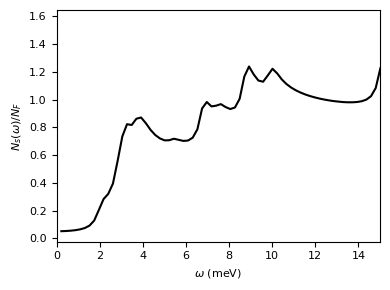

In [18]:
#plot_supercond.plot_qpdos(prefix, filename ='epw1.out', temp=10)
qdos = 'mgb2/epw/mgb2.qdos_010.00'
dos = 'mgb2/epw/epw2.out'
plot_supercond.plot_qpdos(prefix, qdos_file=qdos, dos_file=dos, temp=10)

#### Full-Bandwidth (FBW) Migdal-Eliashberg Equations

We can solve the anisotropic self-energy expressions by considering the energy range within the `fsthick` window instead of using a constant density of states approximations as discussed in [EPW-2023 paper](https://doi.org/10.1038/s41524-023-01107-3).

$${Z}_{n{{{\bf{k}}}}}(i{\omega }_{j})=1+\frac{{k}_{{{{\rm{B}}}}}T}{{\omega }_{j}N({\varepsilon }_{{{{\rm{F}}}}})}\mathop{\sum}\limits_{m{j}^{{\prime} }}\int\,\frac{{\rm {d}}{{{\bf{q}}}}}{{{{\Omega }}}_{{{{\rm{BZ}}}}}}\,\frac{{\omega }_{{j}^{{\prime} }}{Z}_{m{{{\bf{k}}}}+{{{\bf{q}}}}}(i{\omega }_{{j}^{{\prime} }})}{{\theta }_{m{{{\bf{k}}}}+{{{\bf{q}}}}}(i{\omega }_{{j}^{{\prime} }})}\lambda (n{{{\bf{k}}}},m{{{\bf{k}}}}+{{{\bf{q}}}},{\omega }_{j}-{\omega }_{{j}^{{\prime} }}),$$

$${\chi}_{n{{{\bf{k}}}}}(i{\omega }_{j})=-\frac{{k}_{{{{\rm{B}}}}}T}{N({\varepsilon }_{{{{\rm{F}}}}})}\mathop{\sum}\limits_{m{j}^{{\prime} }}\int\,\frac{{\rm {d}}{{{\bf{q}}}}}{{{{\Omega }}}_{{{{\rm{BZ}}}}}}\,\frac{{\varepsilon }_{m{{{\bf{k}}}}+{{{\bf{q}}}}}-{\mu }_{{{{\rm{F}}}}}+{\chi }_{m{{{\bf{k}}}}+{{{\bf{q}}}}}(i{\omega }_{{j}^{{\prime} }})}{{\theta }_{m{{{\bf{k}}}}+{{{\bf{q}}}}}(i{\omega }_{{j}^{{\prime} }})}\lambda (n{{{\bf{k}}}},m{{{\bf{k}}}}+{{{\bf{q}}}},{\omega }_{j}-{\omega }_{{j}^{{\prime} }}),$$

$${\phi }_{n{{{\bf{k}}}}}(i{\omega }_{j})=\frac{{k}_{{{{\rm{B}}}}}T}{N({\varepsilon }_{{{{\rm{F}}}}})}\mathop{\sum}\limits_{m{j}^{{\prime} }}\int\,\frac{{\rm {d}}{{{\bf{q}}}}}{{{{\Omega }}}_{{{{\rm{BZ}}}}}}\,\frac{{\phi }_{m{{{\bf{k}}}}+{{{\bf{q}}}}}(i{\omega }_{{j}^{{\prime} }})}{{\theta }_{m{{{\bf{k}}}}+{{{\bf{q}}}}}(i{\omega }_{{j}^{{\prime} }})}\left[\lambda (n{{{\bf{k}}}},m{{{\bf{k}}}}+{{{\bf{q}}}},{\omega }_{j}-{\omega }_{{j}^{{\prime} }})-N({\varepsilon }_{{{{\rm{F}}}}}){V}_{n{{{\bf{k}}}},m{{{\bf{k}}}}+{{{\bf{q}}}}}\right]$$

where

$${\theta }_{n{{{\bf{k}}}}}(i{\omega }_{j})={\left[\hslash {\omega }_{j}{Z}_{n{{{\bf{k}}}}}(i{\omega }_{j})\right]}^{2}+{\left[{\varepsilon }_{n{{{\bf{k}}}}}-{\mu }_{{{{\rm{F}}}}}+{\chi }_{n{{{\bf{k}}}}}(i{\omega }_{j})\right]}^{2}+{\left[{\phi }_{n{{{\bf{k}}}}}(i{\omega }_{j})\right]}^{2}.$$

The superconducting gap is defined in terms of the renormalization function and the order parameter as: $\Delta_{nk} = \phi_{nk}(i\omega_j) / {Z_{nk}}$. 

This set of equations is supplemented with an equation for the electron number $N_\rm{e}$, which determines the chemical potential $\mu_F$ if `muchem = .true.` is set in the EPW calculation. 

$${N}_{{{{\rm{e}}}}}=\mathop{\sum}\limits_{n}\int\frac{{\rm {d}}{{{\bf{k}}}}}{{{{\Omega }}}_{{{{\rm{BZ}}}}}}\left[1-2{k}_{{{{\rm{B}}}}}T\mathop{\sum}\limits_{j}\frac{{\varepsilon }_{n{{{\bf{k}}}}}-{\mu }_{{{{\rm{F}}}}}+{\chi }_{n{{{\bf{k}}}}}(i{\omega }_{j})}{{\theta }_{n{{{\bf{k}}}}}(i{\omega }_{j})}\right],$$
Here, $N_\rm{e}$ is the number of electrons per unit cell.

In FBW calculations, use the tag `fbw=.true`. We can either keep the chemical potential constant or vary the chemical potential using the input tag `muchem=.true.`.

In [20]:
#mgb2.nscf_file='scf'
#mgb2.scf_fold='scf'
#mgb2.nscf_file='nscf'
#mgb2.nscf_fold='nscf'
#mgb2.ph_file='ph'
#mgb2.ph_fold='ph'
#mgb2.epw_fold='epw'

mgb2.epw(epwin={ 'elph':'.true.',
                 'fsthick':0.2,
                 'degaussw':0.05,
                 'degaussq':0.5, #phonon smearing
                 'ephwrite':'.true.',
                 'eliashberg':'.true.',
                 'iverbosity':2, 
                 #'fermi_plot':'.true.',
                 'laniso':'.true.',
                 'limag':'.true.',
                 'fbw':'.true.',
                 'lpade':'.true.',
                 'nsiter': '500',
                 'conv_thr_iaxis':'1.0d-3',
                 'wscut' :'0.5', # maximum matsubara freq. cutoff
                 'muc':'0.1', 
                 'nstemp':'4',
                 'temps':'10 30',
                 'nkf1':20,'nkf2':20,'nkf3':20,
                 'nqf1':10,'nqf2':10,'nqf3':10,
                 'mp_mesh_k':'.true.', # uses k-point symmetry
                 'clean_supercond':None},
         name='epw3')

mgb2.prepare(4, type_run='epw3')
mgb2.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 8 /home/shashi-phy/codes/q-e/bin/epw.x -nk 8 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 0.0s (4809.80/s)     

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Plot saved as: /home/shashi-phy/codes/epw_notebook/notebooks_basic/mgb2_gap_aniso_vs_temp.pdf


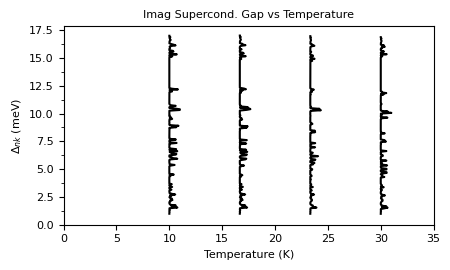

In [21]:
plot_supercond.gap_aniso_temp(prefix, tempmax=35)

##### Anisotropic FBW+$\mu$ calculations

In [22]:
mgb2.epw(epwin={ 'elph':'.true.',
                 'fsthick':0.2,
                 'degaussw':0.05,
                 'degaussq':0.5, #phonon smearing
                 'ephwrite':'.true.',
                 'eliashberg':'.true.',
                 'iverbosity':2, 
                 #'fermi_plot':'.true.',
                 'laniso':'.true.',
                 'limag':'.true.',
                 'fbw':'.true.',
                 'muchem':'.true.',
                 'lpade':'.true.',
                 'nsiter': '500',
                 'conv_thr_iaxis':'1.0d-3',
                 'wscut' :'0.5', # maximum matsubara freq. cutoff
                 'muc':'0.1', 
                 'nstemp':'4',
                 'temps':'10 30',
                 'nkf1':20,'nkf2':20,'nkf3':20,
                 'nqf1':10,'nqf2':10,'nqf3':10,
                 'mp_mesh_k':'.true.', # uses k-point symmetry
                 'clean_supercond':None},
         name='epw3')

mgb2.prepare(4, type_run='epw3')
mgb2.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 8 /home/shashi-phy/codes/q-e/bin/epw.x -nk 8 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 0.0s (3047.37/s)     

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Plot saved as: /home/shashi-phy/codes/epw_notebook/notebooks_basic/mgb2_gap_aniso_vs_temp.pdf


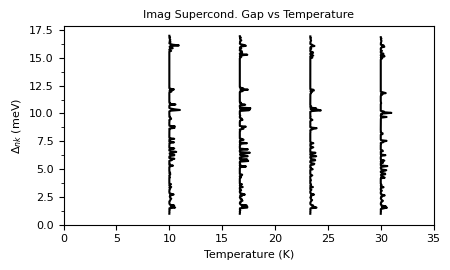

In [23]:
plot_supercond.gap_aniso_temp(prefix, tempmax=35)

##### Plotting and Comparing Results from FSR, FBW and FBW+$\mu$ Calculations

NOTE: If you want to make a plot to compare the superconducting gap using FSR, FBW and FBW+$\mu$ type of calculations, after performing FBW and FBW+$\mu$ calculations, move the `mgb2.imag_aniso_gap0` to folders named as fbw and fbw_mu as the files are overwritten while running each type of calculations. 

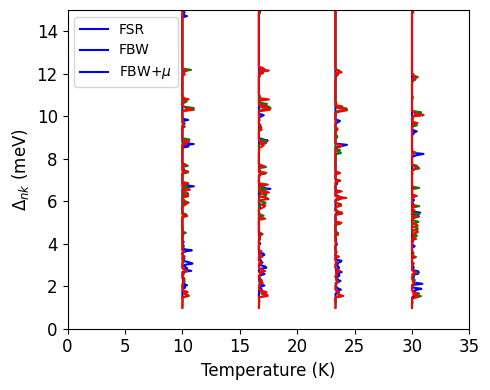

In [7]:
plot_supercond.gap_aniso_fsr_fbw_mu_temp(prefix, tempmax=35, font=12)